```
 Name: 張宸愷
 ID: 0710018
```


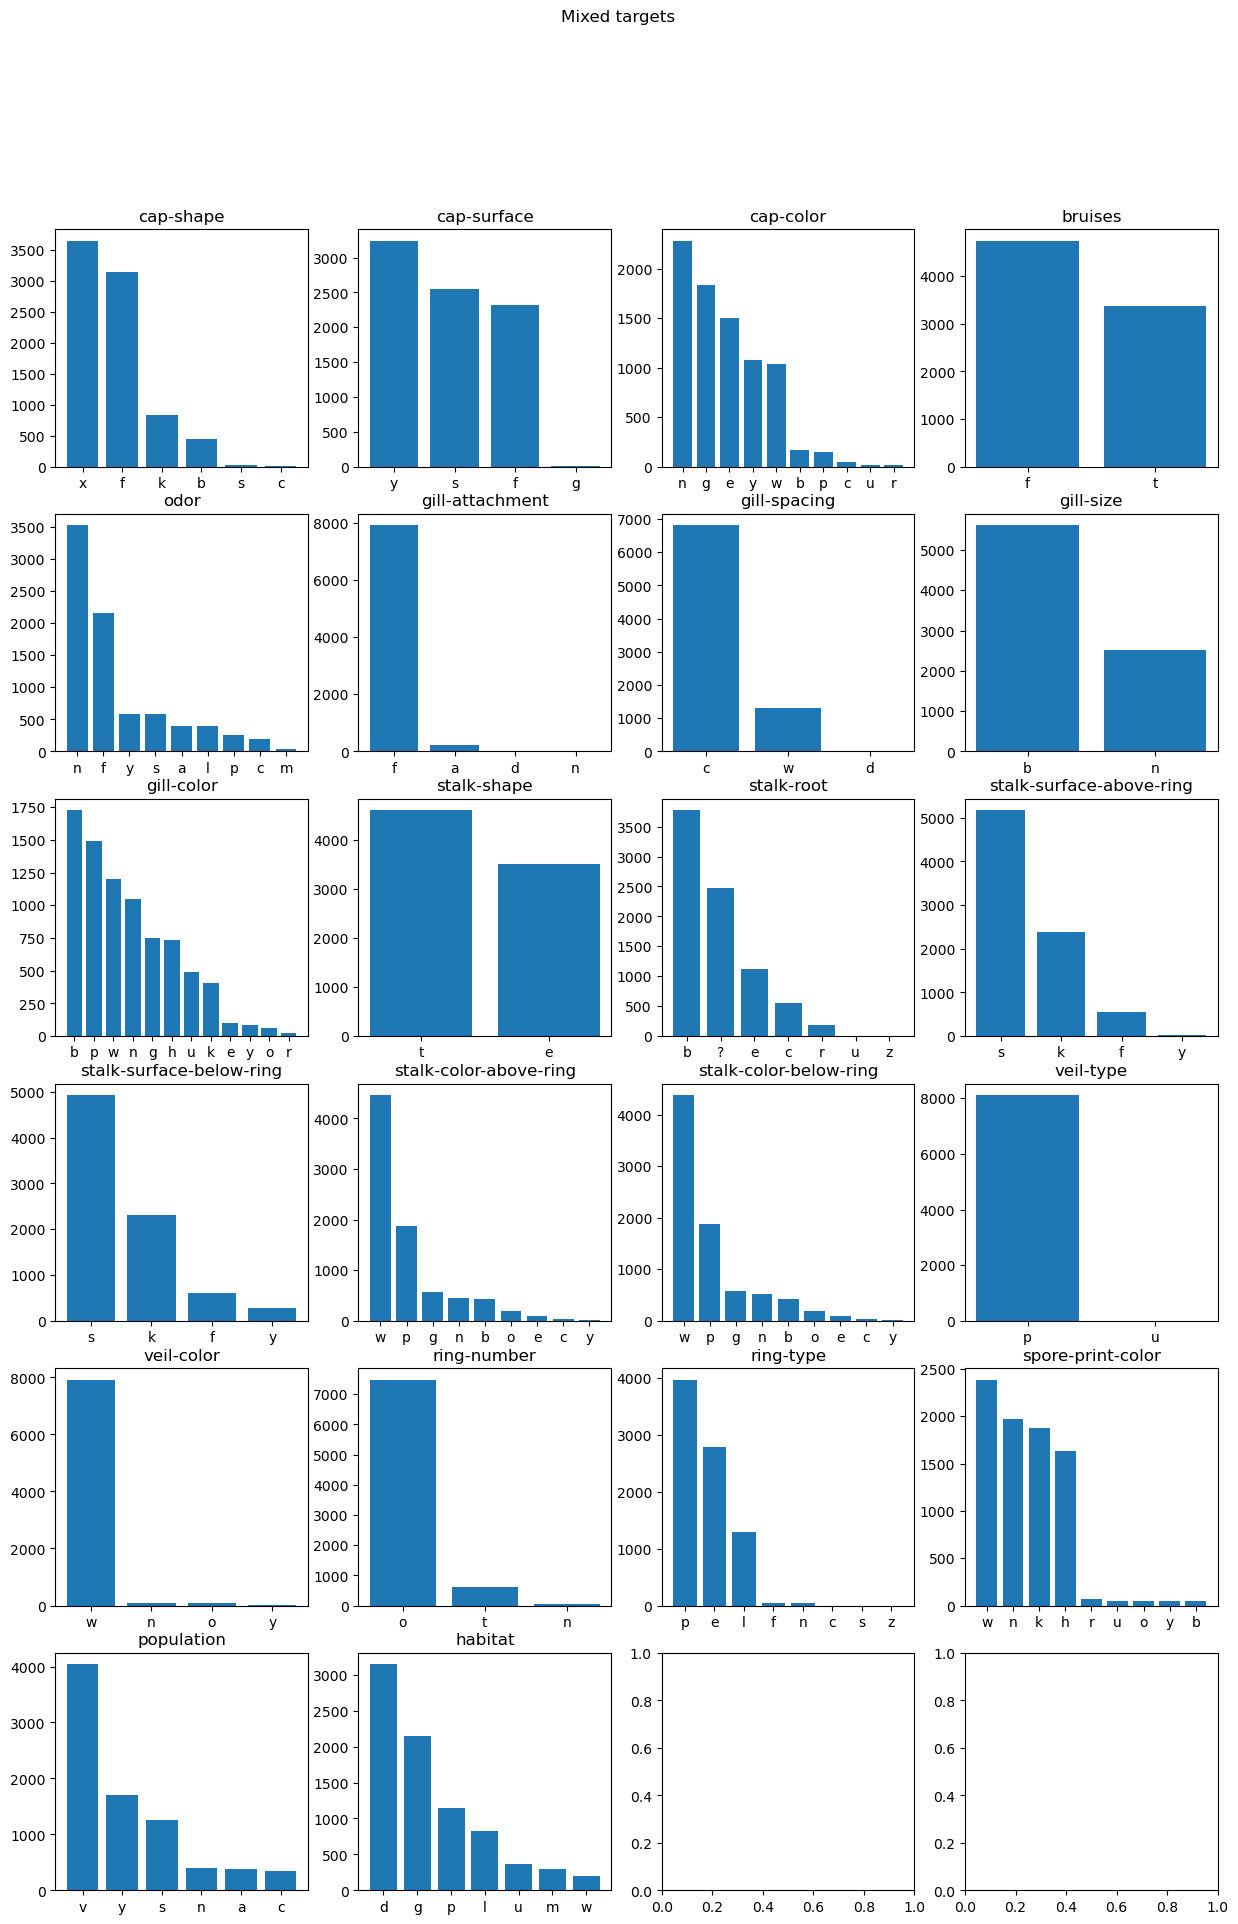

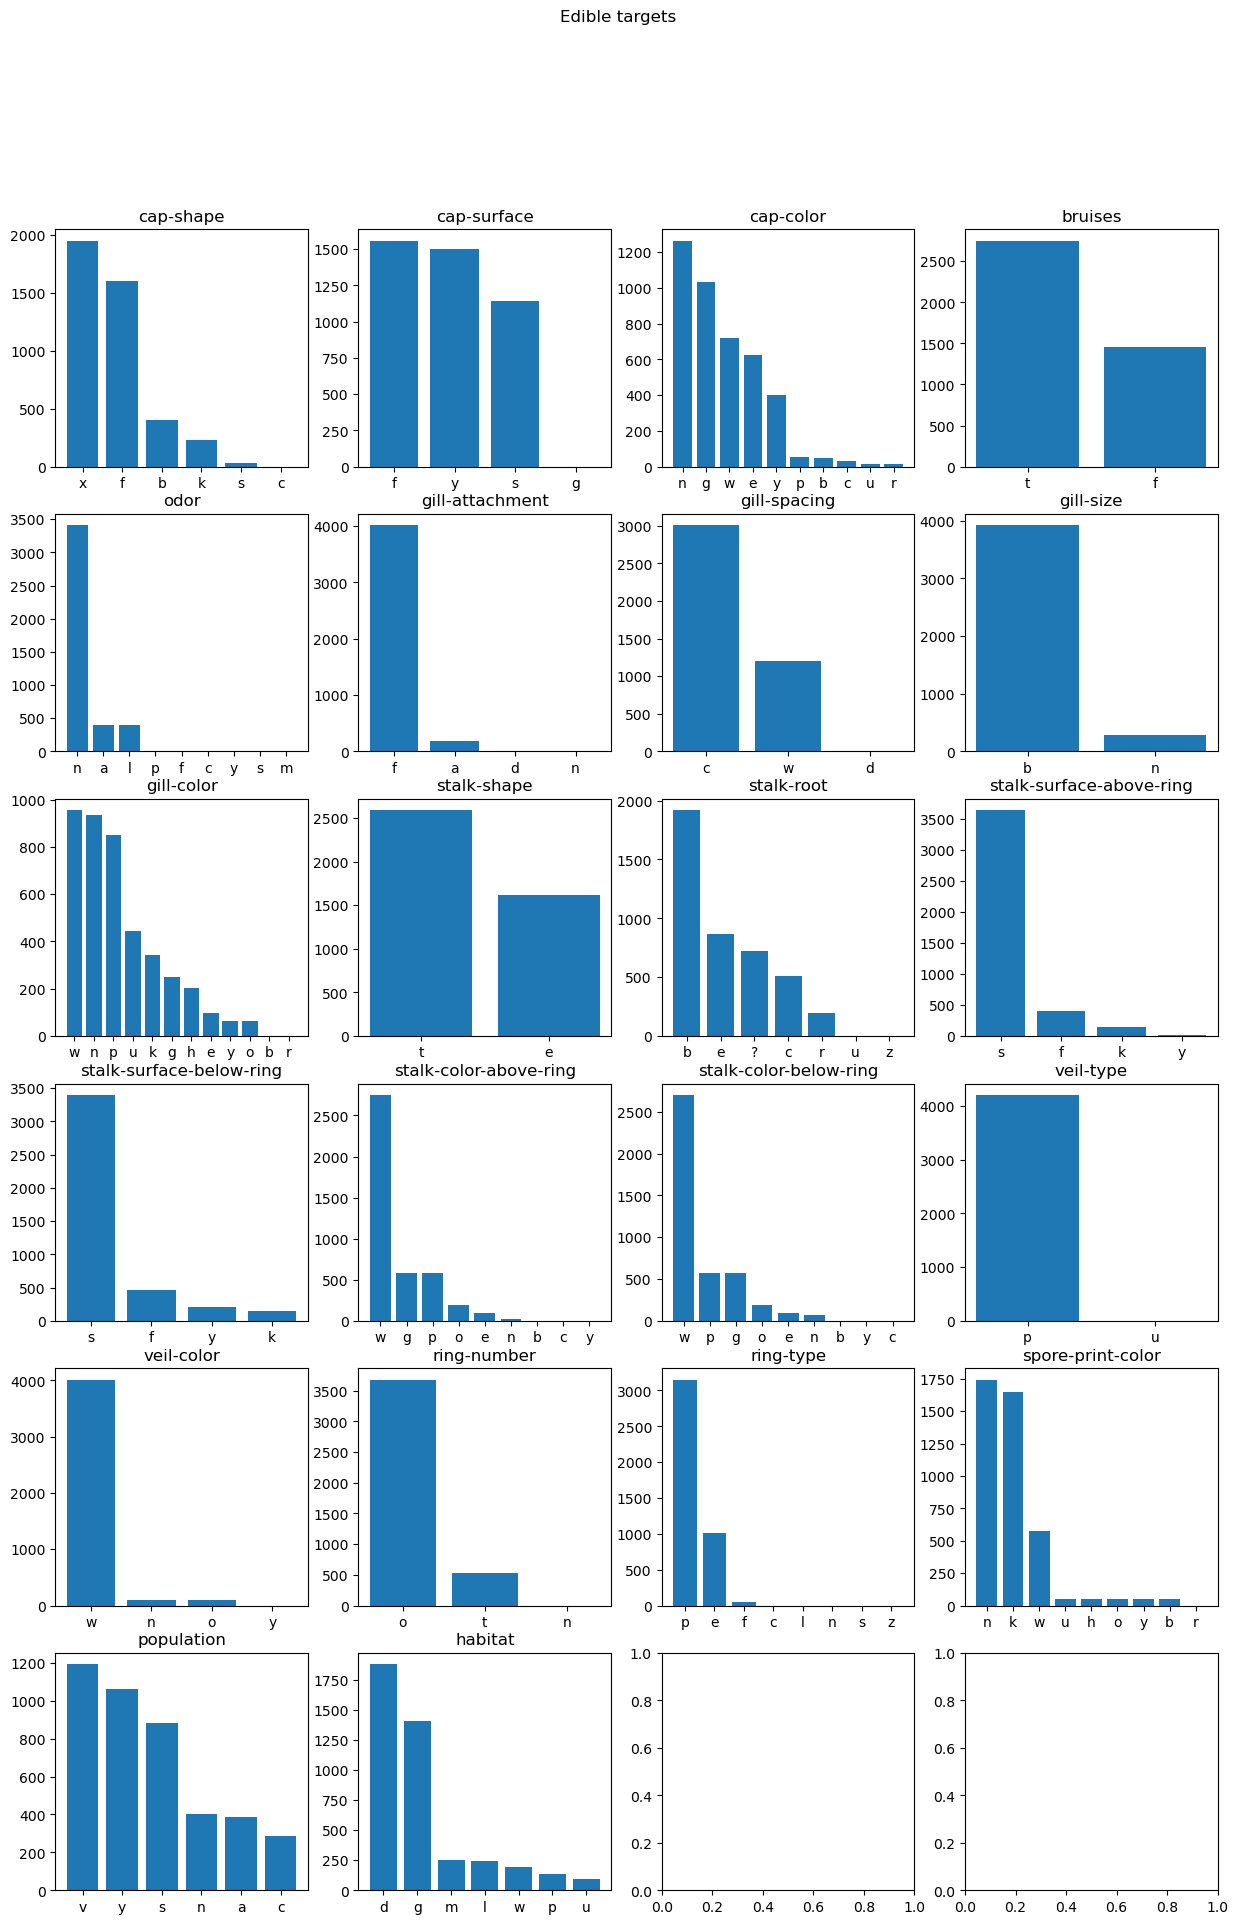

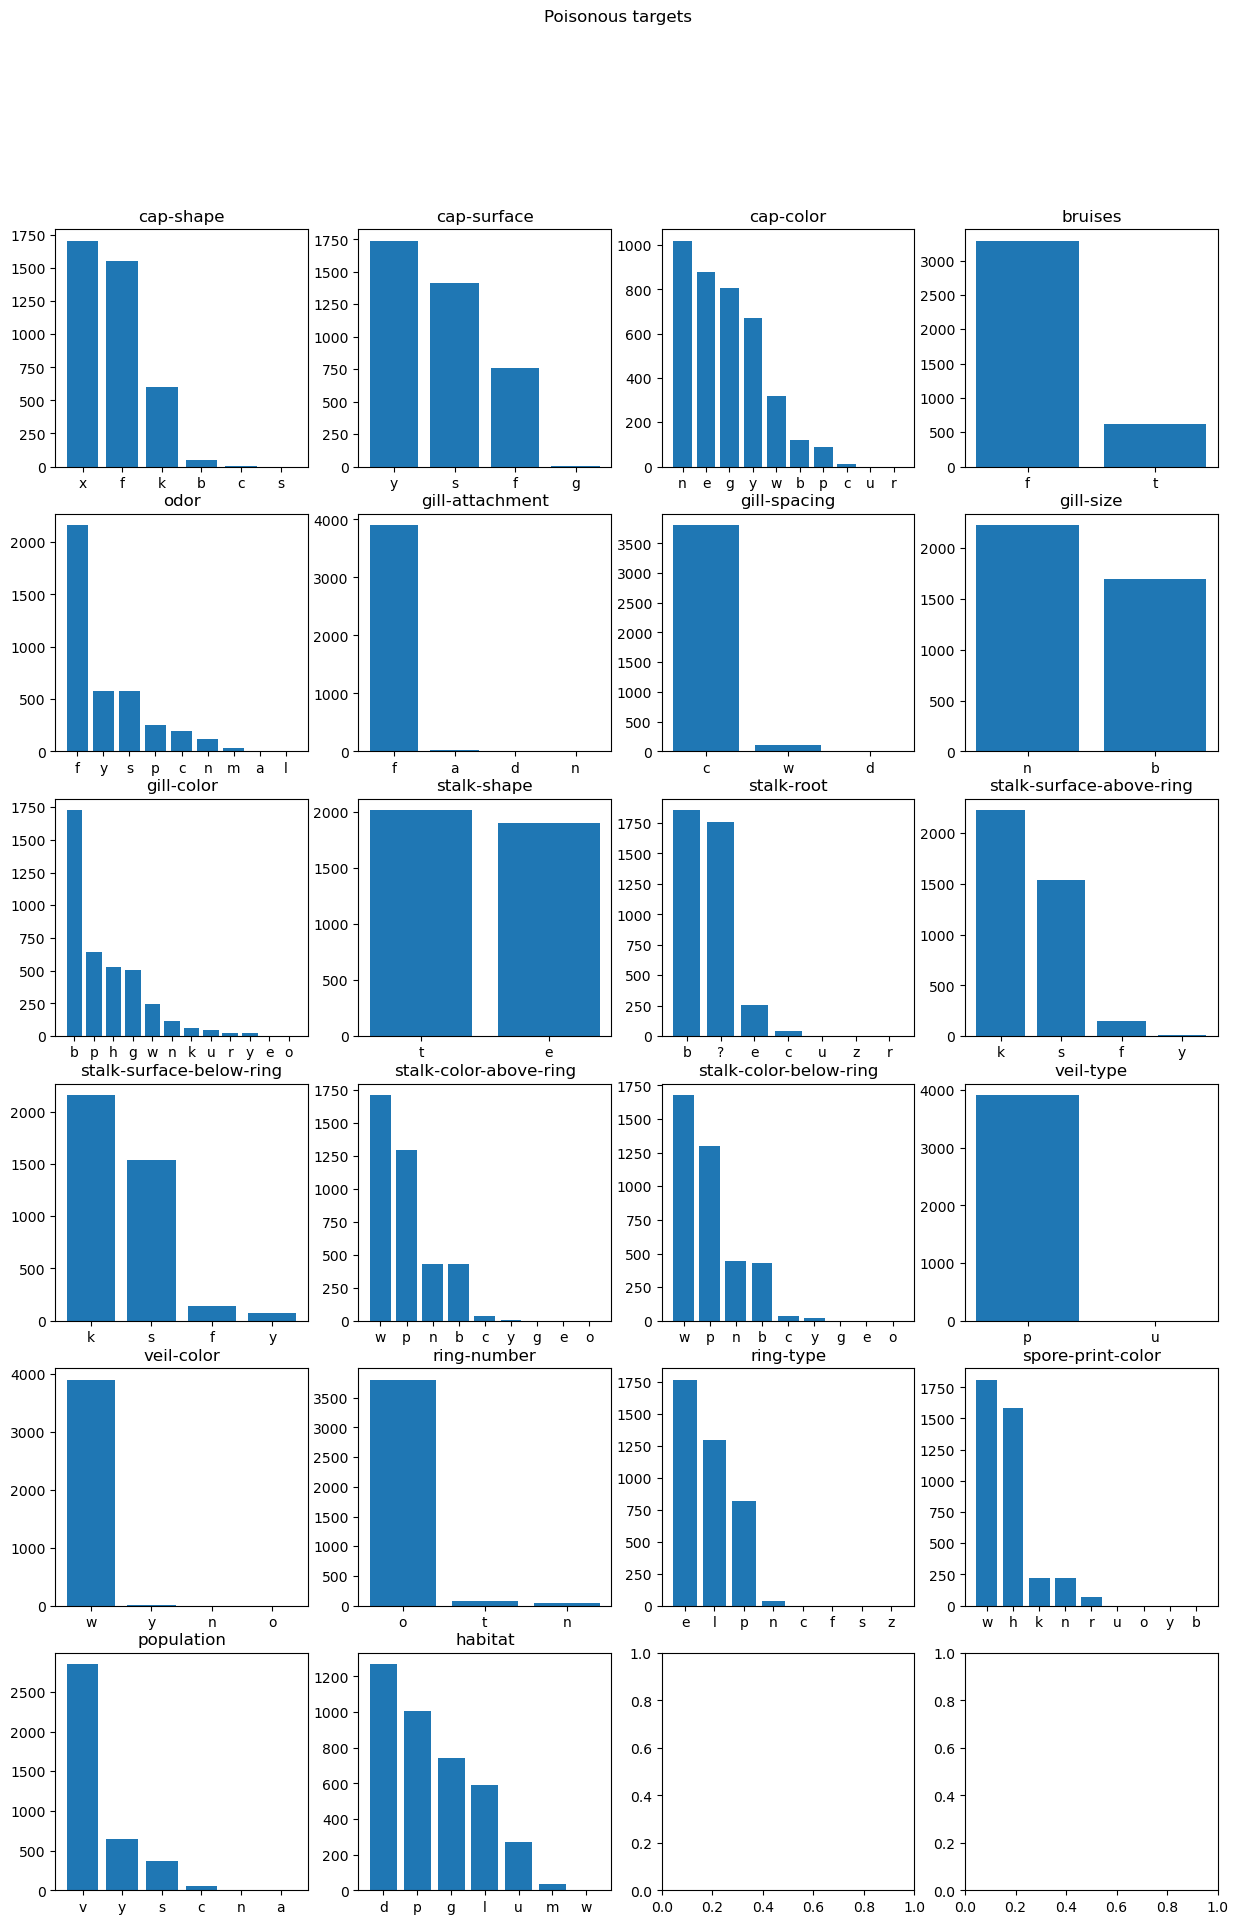

In [24]:
# data visualization

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

visual_data: pd.DataFrame = pd.read_csv(
    "data/agaricus-lepiota.data", sep=",", header=None)

titles = ["cap-shape",
          "cap-surface",
          "cap-color",
          "bruises",
          "odor",
          "gill-attachment",
          "gill-spacing",
          "gill-size",
          "gill-color",
          "stalk-shape",
          "stalk-root",
          "stalk-surface-above-ring",
          "stalk-surface-below-ring",
          "stalk-color-above-ring",
          "stalk-color-below-ring",
          "veil-type",
          "veil-color",
          "ring-number",
          "ring-type",
          "spore-print-color",
          "population",
          "habitat"]

generate_graph = True

if (generate_graph):
    zero_instance = {6: ['a', 'd', 'f', 'n'], 7: ['c', 'w', 'd'], 11: [
        'b', 'c', 'u', 'e', 'z', 'r', '?'], 16: ['p', 'u'], 19: ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z']}

    # plot mixed
    fig, axs = plt.subplots(6, 4, figsize=(15, 22), dpi=100)
    for c in range(1, 23):
        if c in zero_instance.keys():
            cur = visual_data[c].value_counts(sort=False).reindex(
                zero_instance[c], fill_value=0).sort_values(ascending=False)
        else:
            cur = visual_data[c].value_counts(sort=False).reindex(
                visual_data[c].unique(), fill_value=0).sort_values(ascending=False)

        axs[int((c-1)/4), (c-1) % 4].bar(cur.index, cur.values)
        axs[int((c-1)/4), (c-1) % 4].set_title(titles[c-1])

    fig.suptitle("Mixed targets")

    # plot edible
    selector = visual_data[0] == 'e'
    fig, axs = plt.subplots(6, 4, figsize=(15, 22), dpi=100)
    for c in range(1, 23):
        if c in zero_instance.keys():
            cur = visual_data[selector][c].value_counts(sort=False).reindex(
                zero_instance[c], fill_value=0).sort_values(ascending=False)
        else:
            cur = visual_data[selector][c].value_counts(sort=False).reindex(
                visual_data[c].unique(), fill_value=0).sort_values(ascending=False)

        axs[int((c-1)/4), (c-1) % 4].bar(cur.index, cur.values)
        axs[int((c-1)/4), (c-1) % 4].set_title(titles[c-1])

    fig.suptitle("Edible targets")

    # plot poisonous
    selector = visual_data[0] == 'p'
    fig, axs = plt.subplots(6, 4, figsize=(15, 22), dpi=100)
    for c in range(1, 23):
        if c in zero_instance.keys():
            cur = visual_data[selector][c].value_counts(sort=False).reindex(
                zero_instance[c], fill_value=0).sort_values(ascending=False)
        else:
            cur = visual_data[selector][c].value_counts(sort=False).reindex(
                visual_data[c].unique(), fill_value=0).sort_values(ascending=False)

        axs[int((c-1)/4), (c-1) % 4].bar(cur.index, cur.values)
        axs[int((c-1)/4), (c-1) % 4].set_title(titles[c-1])

    fig.suptitle("Poisonous targets")



    

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# some constants
alpha_smoothing = 1
mode = "kfold"

# load csv
mush = pd.read_csv("data/agaricus-lepiota.data", sep=",", header=None)
mush = mush.drop(columns=11)  # drop features with with missing values

# encode the categorical features
encoder = OrdinalEncoder(dtype=np.int8)
encoder.fit(mush)
data = encoder.transform(mush)  # encode the dataset into integers

np.random.shuffle(data)

# The one I wrote myself
def get_metrics(confm: np.ndarray):
    (tn, fp), (fn, tp) = confm
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tn + tp + fn + fp)

    return sensitivity, precision, accuracy


def single_run(training: np.ndarray, validation: np.ndarray):
    cat_NB = CategoricalNB(
        alpha=alpha_smoothing,
        min_categories=[6, 4, 10, 2, 9, 4, 3, 2, 12, 2, 4, 4, 9, 9, 2, 4, 3, 8, 9, 6, 7])
    cat_NB.fit(training[:, 1:], training[:, 0])

    prediction = cat_NB.predict(validation[:, 1:])
    validation = encoder.inverse_transform(
        validation)  # get back the category labels
    mod_pred = np.zeros(validation.shape)
    # insert them into a fake ndarray with the same shape
    mod_pred[:, 0] = prediction
    # so that we can do the inverse transform
    mod_pred = encoder.inverse_transform(mod_pred)  # get back the labels
    confm = confusion_matrix(
        validation[:, 0], mod_pred[:, 0], labels=["p", "e"])
    r = classification_report(
        validation[:, 0], mod_pred[:, 0], digits=8, output_dict=True)

    ro = {}
    for k in ['p', 'e']:
        ro[k] = np.array([r[k]["recall"], r[k]["precision"], r["accuracy"]])
    return confm, ro


def print_metrics(r: dict(), confm: np.ndarray, name: str = ""):
    print(name)
    print("""
    | category | recall | precision | accuracy |
    |----|----|----|----|
    | p | {} | {} | {} |
    | e | {} | {} | {} |
      """.format(*r["p"],
                 *r["e"]))
    print("""
    |  | p(pred) | e(pred) |
    |----|----|----|
    | p(true) | {} | {} |
    | e(true) | {} | {} |    
    """.format(confm[0, 0], confm[0, 1], confm[1, 0], confm[1, 1]))


training = data.copy()

if mode == "holdout":

    ratio = 0.7
    # split data 7:3
    validation = training[int(training.shape[0]*ratio):].copy()
    training = training[0:int(training.shape[0]*ratio)]
    # train and validate
    confm, rs = single_run(training, validation)

else:
    kf = KFold(n_splits=3) # kfold
    sum = []
    rs = {"p":np.zeros((3)), "e":np.zeros((3))}
    for train_i, valid_i in kf.split(X=training[:, 1:]):
        # train and validate
        confm, r = single_run(
            training[train_i], training[valid_i])
        rs["e"] += r["e"]
        rs["p"] += r["p"]
        sum.append(confm)
    rs["e"] /= 3 # average the folds' metricses
    rs["p"] /= 3
    confm = np.sum(sum, axis=0) / 3  # average the confusion matrix

print_metrics(rs, confm)


# Results

----

## Holdout

### No smoothing
classification metrics:

| category | recall | precision | accuracy |
|------|------|------|------|
| p | 0.9982456140350877 | 0.9991220368744512 | 0.9987694831829368 |
| e | 0.9992295839753467 | 0.9984603541185527 | 0.9987694831829368 |
    
confusion matrix:

|  | p(pred) | e(pred) |
|----|----|----|
| p(true) | 1138 | 2 |
| e(true) | 1 | 1297 |    


### Smoothing with alpha = 1
classfication metrics:

| category | recall | precision | accuracy |
|----|----|----|----|
| p | 0.915016501650165 | 0.9946188340807175 | 0.9552912223133716 |
| e | 0.9951060358890701 | 0.9221466364323507 | 0.9552912223133716 |
    
confusion matrix:

|  | p(pred) | e(pred) |
|----|----|----|
| p(true) | 1109 | 103 |
| e(true) | 6 | 1220 | 

----

## KFold

### No smoothing
classfication metrics:

| category | recall | precision | accuracy |
|----|----|----|----|
| p | 0.9992190492317491 | 0.9941676783636351 | 0.9967996061053667 |
| e | 0.994520432542728 | 0.9992966640927565 | 0.9967996061053667 |
    
confusion matrix:

|  | p(pred) | e(pred) |
|----|----|----|
| p(true) | 1304.3333333333333 | 1.0 |
| e(true) | 7.666666666666667 | 1395.0 | 

### Smoothing with alpha = 1
classification metrics:
| category | recall | precision | accuracy |
|----|----|----|----|
| p | 0.9193585367653623 | 0.9936397683159311 | 0.9582717872968981 |
| e | 0.9945855859738145 | 0.9298344589157908 | 0.9582717872968981 |
    
confusion matrix:

|  | p(pred) | e(pred) |
|----|----|----|
| p(true) | 1200.0 | 105.33333333333333 |
| e(true) | 7.666666666666667 | 1395.0 |  
      

# Comparison and Conclusion
As we can see, the performance without laplace smoothing in both KFold and Holdout is better. It's possible that the operation of smoothing decreases the model's accuracy, but in turn, enhances the model's ability to generalize to unseen data. Thus, it's a necessary tradeoff.

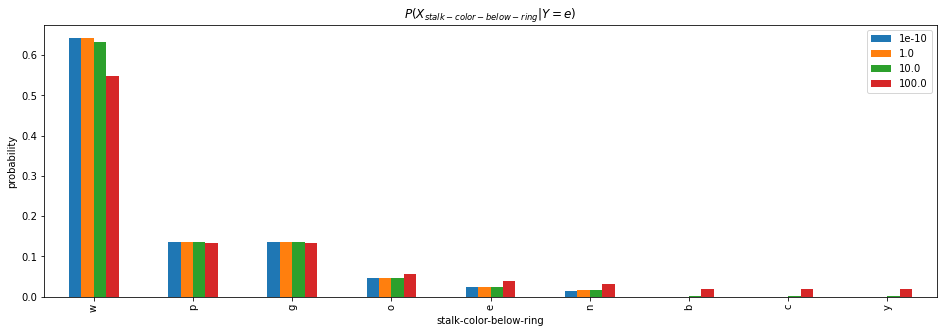

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

generate_graph = True

visual_data: pd.DataFrame = pd.read_csv(
    "data/agaricus-lepiota.data", sep=",", header=None)


def laplace(alpha=1e-10):
    edible_sel = visual_data[0] == 'e'
    edible = visual_data[edible_sel]
    edible_y = edible.shape[0]

    es = edible[15].value_counts(sort=False).reindex( # add missing values
        ['w', 'p', 'n', 'b', 'c', 'y', 'g', 'e', 'o'], fill_value=0).sort_values(ascending=False)
    tau = 9
    # print(es.index)
    vals = dict()
    for i in es.index:
        vals[i] = (es[i] + alpha) / (edible_y + tau * alpha)
    # print(vals)
    return vals


if(generate_graph):

    ls = [1e-10, 1, 10, 100]
    vals:list = []
    for i in range(4):
        v = laplace(ls[i])
        vals.append(v)
    def trans(name):
        return ls[name]
    df = pd.DataFrame(vals).rename(mapper=trans).T

    df.plot.bar(figsize=(16, 5))
    
    plt.title("$P(X_{stalk-color-below-ring} | Y = e)$")
    plt.xlabel("stalk-color-below-ring")
    plt.ylabel("probability")